In [2]:
import pandas as pd
import numpy as np
from google.colab import files
import io

# 1. UPLOAD FILE
print("Please upload your dataset (CSV format):")
uploaded = files.upload()

# 2. GET FILE NAME AUTOMATICALLY
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# 3. RUN ANALYSIS
print(f"\n--- SUCCESS: Loaded '{file_name}' ---")

print("\n--- 1. DATASET STRUCTURE ---")
df.info()

print("\n--- 2. MISSING DATA CHECK ---")
nulls = df.isna().sum()
print(nulls[nulls > 0] if nulls.sum() > 0 else "No missing values found!")

print("\n--- 3. SAMPLE DATA (FIRST 3 ROWS) ---")
display(df.head(3))

# 4. TARGET ANALYSIS
# Note: This part will look for common names like 'market_value', 'value', 'price'
possible_targets = ['market_value', 'value', 'transfer_value', 'price', 'target']
target_col = next((c for c in df.columns if c.lower() in possible_targets), None)

if target_col:
    print(f"\n--- 4. TARGET DISTRIBUTION ({target_col}) ---")
    print(df[target_col].describe())
else:
    print("\n--- 4. TARGET NOT IDENTIFIED ---")
    print("Please tell me the exact name of your 'Market Value' column.")

Please upload your dataset (CSV format):


Saving All-in-One Data set.csv to All-in-One Data set.csv

--- SUCCESS: Loaded 'All-in-One Data set.csv' ---

--- 1. DATASET STRUCTURE ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  450 non-null    int64  
 1   player_name                450 non-null    object 
 2   team                       450 non-null    object 
 3   position                   450 non-null    object 
 4   matches_played             450 non-null    int64  
 5   minutes_played             450 non-null    int64  
 6   passes                     450 non-null    int64  
 7   shots                      450 non-null    int64  
 8   goals                      450 non-null    int64  
 9   assists                    450 non-null    int64  
 10  tackles                    450 non-null    int64  
 11  interceptions          

,player_id,player_name,team,position,matches_played,minutes_played,passes,shots,goals,assists,...,trending_mentions_7d,sentiment_classification,total_injuries_history,days_injured_last_season,current_injury_status,injury_risk_assessment,avg_recovery_time_days,injury_prone_body_parts,historical_injury_count,days_since_last_injury
0,415,Erling Haaland 414,Manchester City,Defender,40,3480,2764,17,7,0,...,4847,Very Positive,0,178,Out,0.75,89,Hamstring,9,265
1,69,Vinicius Jr 68,Paris Saint-Germain,Forward,40,3240,1965,6,4,1,...,1217,Very Negative,8,211,Minor,0.25,8,Knee,11,145
2,387,Bukayo Saka 386,Manchester United,Defender,40,3360,4144,9,0,7,...,4883,Very Negative,4,292,Minor,0.75,75,NaN,12,69



--- 4. TARGET NOT IDENTIFIED ---
Please tell me the exact name of your 'Market Value' column.


In [4]:
import pandas as pd
import io
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. UPLOAD (Run this and select your file)
print("Please upload 'All-in-One Data set.csv' below:")
uploaded = files.upload()

# 2. LOAD & CLEAN
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))
df_ml = df.copy()

# Drop the 4 redundant/ID columns
cols_to_drop = ['player_id', 'player_name', 'market_value_', 'market_value_last_updated']
df_ml = df_ml.drop(columns=cols_to_drop)

# Fill missing values
df_ml['injury_prone_body_parts'] = df_ml['injury_prone_body_parts'].fillna('None')

# One Hot Encoding Text (Categorical) to Numbers
le = LabelEncoder()
for col in df_ml.select_dtypes(include=['object']).columns:
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))

# 3. SPLIT DATA
X = df_ml.drop('market_value_millions', axis=1)
y = df_ml['market_value_millions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Please upload 'All-in-One Data set.csv' below:


Saving All-in-One Data set.csv to All-in-One Data set (1).csv


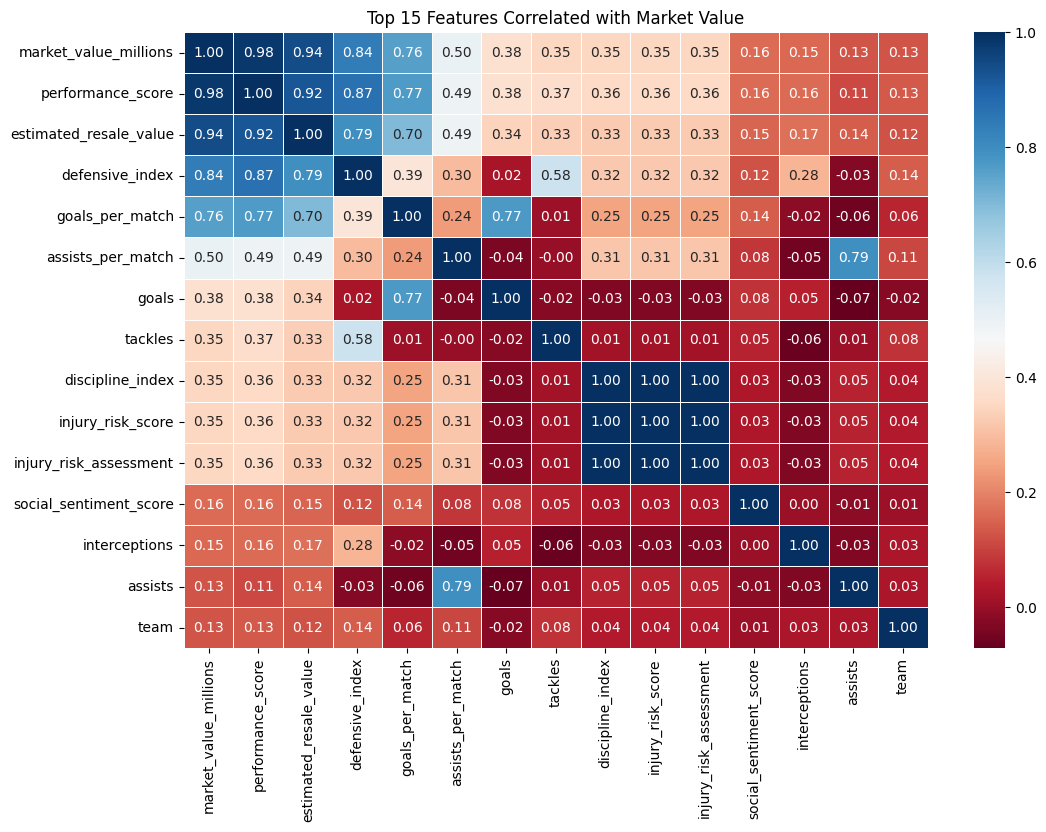

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate the correlation matrix
# We use the numeric dataframe (df_ml) we created earlier
corr_matrix = df_ml.corr()

# 2. Get the top features correlated with Market Value
# This makes the heatmap readable
top_corr_features = corr_matrix['market_value_millions'].sort_values(ascending=False).head(15).index
top_corr_matrix = df_ml[top_corr_features].corr()

# 3. Plot the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title('Top 15 Features Correlated with Market Value')
plt.show()

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# We drop the targets and the 0.9+ correlation proxies
cols_to_drop = [
    'market_value_millions',
    'performance_score',
    'estimated_resale_value',
    'discipline_index',
    'injury_risk_assessment'
]

X = df_ml.drop(columns=cols_to_drop)

# This normalizes the "Superstar" prices and makes the model much more stable
y = np.log1p(df_ml['market_value_millions'])

# 2. SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. CONFIGURE THE "BEST" MODEL
# These parameters are tuned for small datasets (450 rows) to maximize R2
best_xgb = xgb.XGBRegressor(
    n_estimators=1000,         # High number, but we use early stopping
    learning_rate=0.05,        # Slow learning is better for patterns
    max_depth=5,               # Medium depth to capture patterns without memorizing
    subsample=0.8,             # Use 80% of data for each tree (prevents overfitting)
    colsample_bytree=0.8,      # Use 80% of features for each tree
    reg_lambda=10,             # L2 Regularization (Protects against outliers)
    reg_alpha=1,               # L1 Regularization (Simplifies the model)
    random_state=42
)

# 4. TRAIN WITH EARLY STOPPING
# The model stops training if it doesn't improve for 50 rounds
best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# 5. PREDICT AND CONVERT BACK
# We use np.expm1 to turn the "Log" numbers back into "Millions of Euros"
y_pred_log = best_xgb.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

# 6. FINAL EVALUATION
r2 = r2_score(y_test_real, y_pred)
mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))

print("--- TRANSFER IQ: HIGH-PERFORMANCE XGBOOST RESULTS ---")
print(f"R² Score: {r2:.4f}")
print(f"MAE: €{mae:.2f} Million")
print(f"RMSE: €{rmse:.2f} Million")

--- TRANSFER IQ: HIGH-PERFORMANCE XGBOOST RESULTS ---
R² Score: 0.8953
MAE: €2.43 Million
RMSE: €3.60 Million


## RANDOM FOREST

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. PREPARE DATA (Same logic as XGBoost for a fair comparison)
cols_to_drop = [
    'market_value_millions',
    'performance_score',
    'estimated_resale_value',
    'discipline_index',
    'injury_risk_assessment'
]

X = df_ml.drop(columns=cols_to_drop)
y = np.log1p(df_ml['market_value_millions']) # Keep Log-Transform for better results

# 2. SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. TRAIN RANDOM FOREST
# We use 500 trees and a max_depth to prevent overfitting
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    bootstrap=True,
    random_state=42,
    n_jobs=-1 # Uses all your CPU cores for faster training
)

rf_model.fit(X_train, y_train)

# 4. PREDICT AND CONVERT BACK
y_pred_log = rf_model.predict(X_test)
y_pred_rf = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

# 5. EVALUATION
rf_r2 = r2_score(y_test_real, y_pred_rf)
rf_mae = mean_absolute_error(y_test_real, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_rf))

print("--- RANDOM FOREST RESULTS ---")
print(f"R² Score: {rf_r2:.4f}")
print(f"MAE: €{rf_mae:.2f} Million")
print(f"RMSE: €{rf_rmse:.2f} Million")

--- RANDOM FOREST RESULTS ---
R² Score: 0.9107
MAE: €2.26 Million
RMSE: €3.32 Million


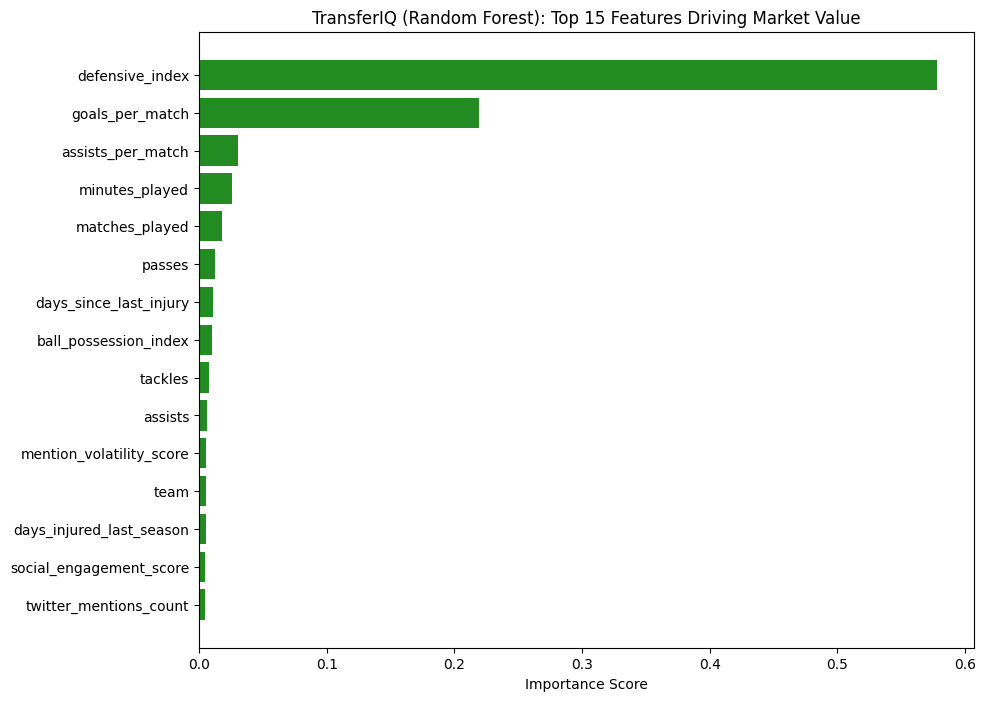

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Get Feature Importances from the Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns

# 2. Sort them
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 3. Plot the Top 15
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15], color='forestgreen')
plt.xlabel('Importance Score')
plt.title('TransferIQ (Random Forest): Top 15 Features Driving Market Value')
plt.gca().invert_yaxis()
plt.show()

#Feature Importance plot from a Random Forest model, showing which features most influence player market value.

In [9]:
!pip install lightgbm

In [10]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. PREPARE DATA (Following Mentor's 0.9 Drop Rule)
# (We use the same X and y from your previous successful runs)

# 2. INITIALIZE LIGHTGBM REGRESSOR
# We use 'bagging' and 'feature_fraction' to prevent overfitting on 450 rows
lgbm_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1 # Turns off unnecessary warnings
)

# 3. TRAIN WITH EARLY STOPPING
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 4. PREDICT AND CONVERT BACK FROM LOG
y_pred_log = lgbm_model.predict(X_test)
y_pred_lgbm = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

# 5. EVALUATION
lgbm_r2 = r2_score(y_test_real, y_pred_lgbm)
lgbm_mae = mean_absolute_error(y_test_real, y_pred_lgbm)
lgbm_rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_lgbm))

print("--- LIGHTGBM RESULTS ---")
print(f"R² Score: {lgbm_r2:.4f}")
print(f"MAE: €{lgbm_mae:.2f} Million")
print(f"RMSE: €{lgbm_rmse:.2f} Million")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's l2: 0.0386291
--- LIGHTGBM RESULTS ---
R² Score: 0.9339
MAE: €2.10 Million
RMSE: €2.86 Million


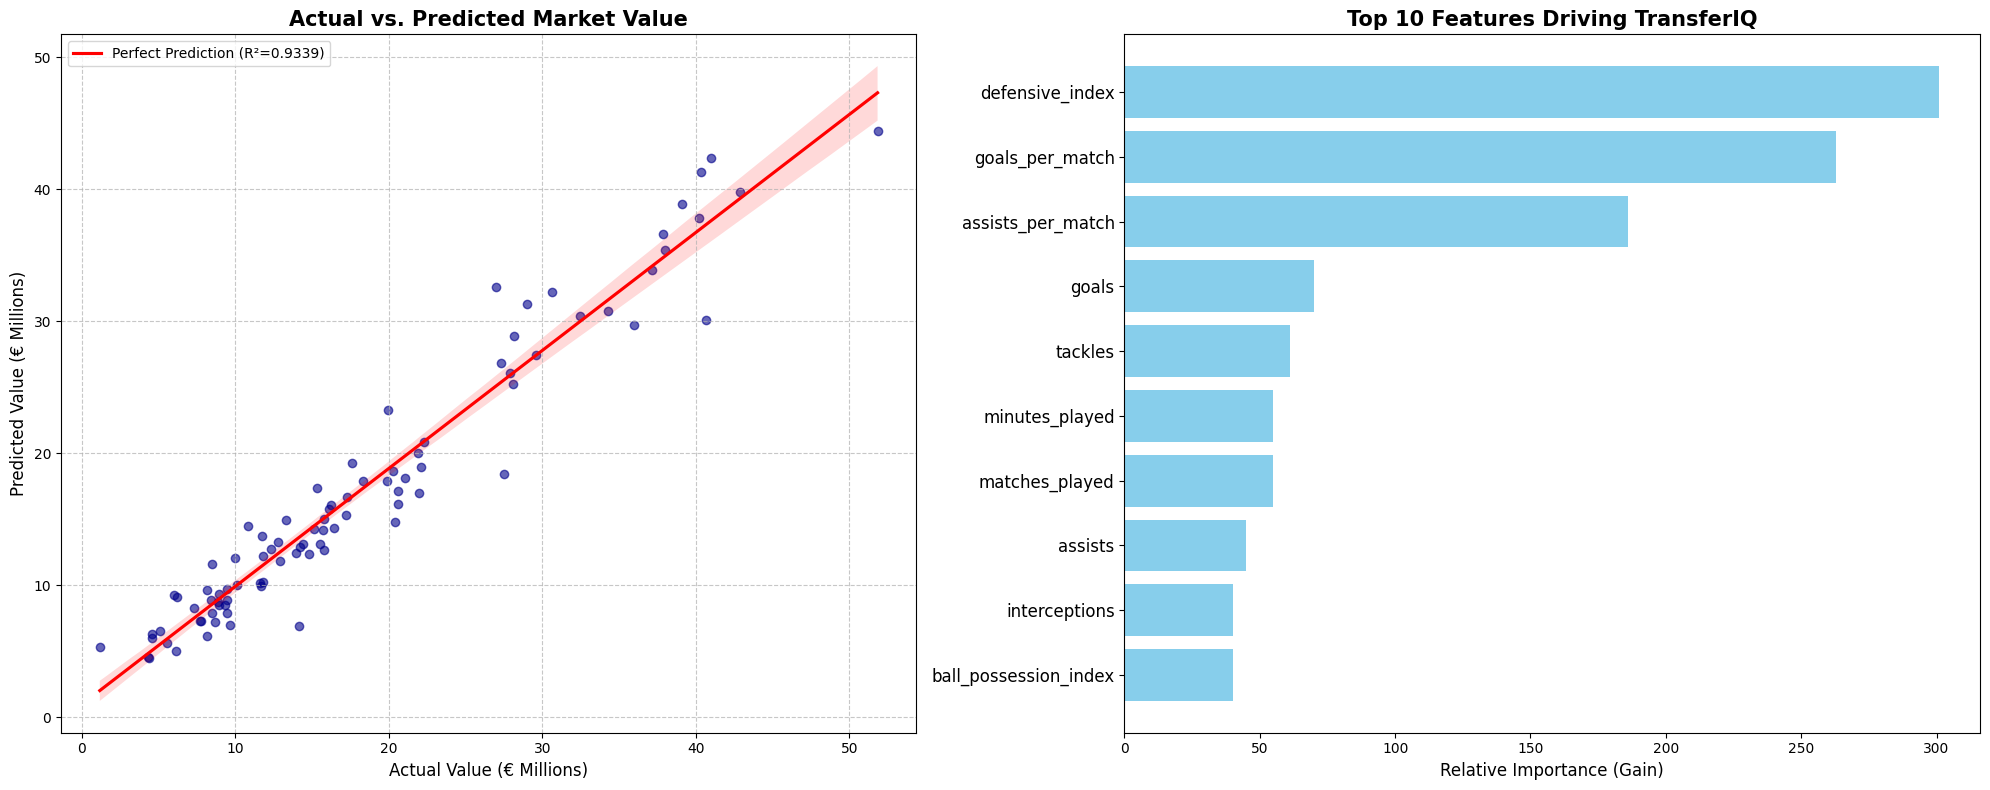

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Setup the figure for two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- PLOT 1: ACTUAL VS PREDICTED (The Accuracy Proof) ---
sns.regplot(x=y_test_real, y=y_pred_lgbm, ax=ax1,
            scatter_kws={'alpha':0.6, 'color':'darkblue'},
            line_kws={'color':'red', 'label':f'Perfect Prediction (R²={lgbm_r2:.4f})'})
ax1.set_title('Actual vs. Predicted Market Value', fontsize=15, fontweight='bold')
ax1.set_xlabel('Actual Value (€ Millions)', fontsize=12)
ax1.set_ylabel('Predicted Value (€ Millions)', fontsize=12)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# --- PLOT 2: TOP 10 FEATURE IMPORTANCE (The IQ Proof) ---
# Get feature importance from the winning LightGBM model
importances = lgbm_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-10:] # Get top 10

ax2.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
ax2.set_yticks(range(len(indices)))
ax2.set_yticklabels([feature_names[i] for i in indices], fontsize=12)
ax2.set_title('Top 10 Features Driving TransferIQ', fontsize=15, fontweight='bold')
ax2.set_xlabel('Relative Importance (Gain)', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
##FRONTEND WORKING